## Library imports

In [1]:
import typing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import erf
from statistics import NormalDist
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,18.27)})
%matplotlib inline

## Dataset Import

In [2]:
alist = pd.read_csv('../data/Peter32.csv')

## Error Functions

In [3]:
def placement_error(analytes_pl, true_pl=None):
    """
    Conpute placement error for a given analyte list result.
    
    Parameters
    ----------
    analytes_pl: 
        list with analyte placements.
    true_pl:
        the true placements that the analytes should have.
        
    Returns
    -------
        returns the placement error
    """
    
    list_len = analytes_pl.shape[0]
    
    if not true_pl:
        true_pl = np.arange(1, list_len + 1)/list_len
       
    return 2 * np.abs(analytes_pl - true_pl).sum() / (list_len - 1)

In [4]:
def cdf(x, mu, sigma):
    """
    Cumulative distribution function for Normal Distribution.
    
    Parameters
    ----------
    x:
        position to calculate P(X < x)
    mu:
        mean of the Normal Distribution.
    sigma:
        standard deviation of the Normal Distribution.
        
    Return
    ------
        cdf at x.
    """
    return 0.5 * (1.0 + erf((x - mu) / (sigma * np.sqrt(2.0))))

In [87]:
def overlap_error(mu, sigma):
    """
    Compute the overlaping error of the analytes.
    
    Parameters
    ----------
    mu:
        mean of the peak per analyte
    sigma:
        standard deviation of the peak per analyte.
        
    Returns
    -------
        The overlaping error of all the analytes.
    """
    indexes = np.argsort(sigma)
    mu_1 = (mu[indexes])[:-1]
    sigma_1 = (sigma[indexes])[:-1]
    var_1 = sigma_1 ** 2
    mu_2 = (mu[indexes])[1:]
    sigma_2 = (sigma[indexes])[1:]
    var_2 = sigma_2 ** 2

    d_var = var_2 - var_1
    d_mu = np.fabs(mu_2 - mu_1)
    
    # Split into two cases: When d_var is zero and when not
    # Case d_var is zero
    zero_d_var = (d_var == 0)
    overlap_area = (1.0 - erf(d_mu[zero_d_var] / (2.0 * sigma_1[zero_d_var] * np.sqrt(2.0)))).sum()
    
    # Case d_var is not zero
    if (~zero_d_var).sum() == 0:
        return overlap_area/zero_d_var.sum()
    
    # reassigne values
    mu_1 = mu_1[~zero_d_var]
    mu_2 = mu_2[~zero_d_var]
    sigma_1 = sigma_1[~zero_d_var]
    sigma_2 = sigma_2[~zero_d_var]
    var_1 = var_1[~zero_d_var]
    var_2 = var_2[~zero_d_var]
    d_var = d_var[~zero_d_var]
    d_mu = d_mu[~zero_d_var]
    
    a = mu_1 * var_2 - mu_2 * var_1
    b = sigma_1 * sigma_2 * np.sqrt(d_mu**2.0 + d_var * np.log(var_2 / var_1))
    x1 = (a + b) / d_var
    x2 = (a - b) / d_var
    overlap_area += (1.0 - (np.fabs(cdf(x1, mu_2, sigma_2) - cdf(x1, mu_1, sigma_1))\
                  + np.fabs(cdf(x2, mu_2, sigma_2) - cdf(x2, mu_1, sigma_1)))).sum()
    return overlap_area/(len(mu) - 1)

## Useful functions definition

In [92]:
def sig(height, mu):
    return np.sqrt((mu**2) * height)

In [93]:
def k(k0, S, phi):
    return (10 ** (-phi * S)) * k0

In [94]:
def xk(k0, S, phi, dt):
    return dt /(k(k0, S, phi) + 1)

In [95]:
def iso_list(anlist, phi):
    k0 = anlist[:,1]
    S = anlist[:,2]
    dt =  (1 - 2 * np.sqrt(0.001))
    return np.sort(dt /((10 ** (-phi * S)) * k0 + 1))

In [96]:
def iso_spot(anlist, phi):
    return pl_error(iso_list(anlist, phi))

In [97]:
def int_(ud, sigd, ua, siga):
    return (2 * siga ** 2 * sigd - 2 * siga * sigd ** 2 \
            + sigd ** 2 * ua + siga ** 2 * ud)\
            / ( siga ** 2 + sigd ** 2)

In [98]:
def bl(ud, sigd, ua, siga):
    first = int_(ud, sigd, ua, siga)
    second = ua - 2 * siga
    return np.stack([first,second], axis=1).max(axis=1)

In [99]:
def bu(ud, sigd, ua, siga):
    first = int_(ud, sigd, ua, siga)
    second = ud + 2 * sigd
    return np.stack([first,second], axis=1).min(axis=1)

In [100]:
def cushlist(res_list):
    return np.concatenate([ np.array([
        0, 10 ** -10]).reshape(1, -1),
        res_list,
        np.array([1, 10 ** -10]).reshape(1, -1)])

In [101]:
def poi(res_list):
    return np.stack(
        [
            bl(res_list[:-2, 0], res_list[:-2, 1], res_list[1:-1, 0], res_list[1:-1, 1]),
            res_list[1:-1, 0],
            bu(res_list[1:-1, 0], res_list[1:-1, 1], res_list[2:, 0], res_list[2:, 1])
        ],
        axis=1
       )

In [102]:
def yval(x_list, chrom):

    denominator = 4 * chrom[:, 1] ** 2
    temp_1 = np.abs(x_list[:, 0] - x_list[:, 1])
    temp_1[temp_1 > chrom[:, 1]] = 0
    temp_1 /= denominator
    
    temp_2 = 1/(2 * chrom[:, 1])
    
    temp_3 = np.abs(x_list[:, 1] - x_list[:, 1])
    temp_3[np.abs(x_list[:, 2] - x_list[:, 1]) > chrom[:, 1]] = 0
    temp_3 /= denominator
    
    return np.stack([temp_1, temp_2, temp_3], axis=1)


In [103]:
def narea(main_list, x_list, y_list):
    return 1 - ((y_list[:, 1] - y_list[:, 0])*(x_list[:, 1] - x_list[:, 0])
            - (y_list[:, 2] - y_list[:, 1])*(x_list[:, 2] - x_list[:, 1])).sum()/(2 * main_list.shape[0])

In [104]:
def lfn(main_list, x_list, y_list):
    return plerror(main_list) + narea(main_list, x_list, y_list)

In [105]:
def isoloss(alist, phi, h):
    chroma = iso_list(alist.values, phi)
    chroma = np.array([chroma, sig(h, chroma)]).T
    schroma = chroma[chroma[:,0].argsort()]
    padlist = cushlist(schroma)
    npoi = poi(padlist)
    ypoi = yval(npoi, schroma)
    lofn = placement_error(schroma[:,0]) + narea(schroma,npoi, ypoi)
    
    return chroma, schroma, narea(schroma,npoi, ypoi)

In [106]:
phis = np.linspace(0.001, 0.999, 999)

In [130]:
def loss_suhas():
    isoloss(alist, 0.34, 0.001)

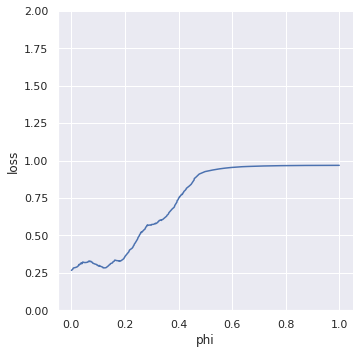

In [108]:
sns.relplot(x='phi', y='loss', data=data, kind='line')
plt.ylim(0, 2)
plt.show()

In [115]:
def my_isoloss(alist, phi, h):
    chroma = iso_list(alist.values, phi)
    chroma = np.array([chroma, sig(h, chroma)]).T
    schroma = chroma[chroma[:,0].argsort()]
    lofn = placement_error(schroma[:,0]) + overlap_error(schroma[:,0], schroma[:,1])
    
    return chroma, schroma, lofn

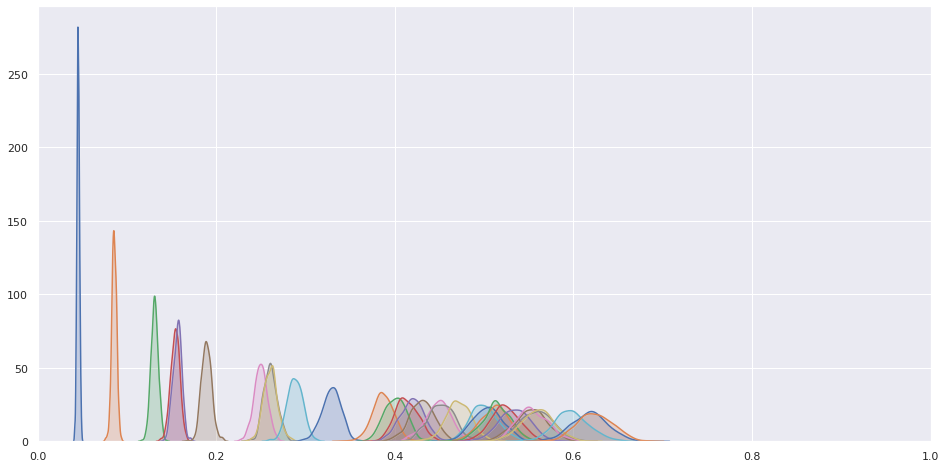

In [116]:
plt.rcParams['figure.figsize'] = (16,8)
for mu, sigma in b:
    x = np.random.normal(mu, sigma, size=500)
    sns.kdeplot(x, shade=True)
    plt.xlim((0,1))

In [120]:
def my_loss():
    for phi in phis:
        my_isoloss(alist, phi, 0.001)


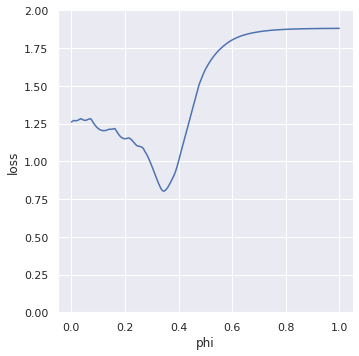

In [118]:
sns.relplot(x='phi', y='loss', data=data, kind='line')
plt.ylim(0, 2)
plt.show()

In [114]:
data.sort_values('loss')

,loss,phi
0,0.219114,0.001
1,0.220408,0.002
2,0.221763,0.003
3,0.223178,0.004
106,0.224366,0.107
...,...,...
994,0.999510,0.995
995,0.999515,0.996
996,0.999519,0.997
997,0.999524,0.998


In [131]:
%timeit  isoloss(alist, 0.34, 0.001)

309 µs ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [132]:
%timeit  my_isoloss(alist, 0.34, 0.001)

228 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [127]:
0.015625*1000

15.625

65.21739130434783